## Immersion Geometry

In this case, we will see how to use Riemannian geometry on any manifold defined by an immersion into a Euclidean space, such as high-dimensional surfaces immersed in a Euclidean space.Specifically, we focus on the case of an embedded manifold $M$ that can be defined by a map f: $f: M \rightarrow \mathbb{R}^n$ called the immersion, whose differential $df_x$ is injective for all $x \in M$.

This immersion allows to define the pull-back metric $g$ on $M$, as:$$g : T_xM \times T_x M \rightarrow \mathbb{R}\\
u, v \rightarrow &lt;df_x.u, df_x.v&gt;$$where $&lt;,&gt;$ represents the Euclidean inner-product of the embedding space.

The pull-back metric gives a structure of Riemannian manifold to $M$. In particular, we can compute the Riemannian exp and log maps, the Riemannian distance, the Riemannian parallel transport, etc. 

[Pullback metrics](https://www.researchgate.net/publication/320234759_Introduction_to_pullback_metric) : Let $\phi : M → N$ be a smooth map between (smooth) manifolds $M$ and $N$, and suppose $f : N → R$ is a smooth function on $N$. Then the pullback of $f$ by $\phi$ is the smooth function $\phi^{∗}f$ on $M$ defined by $(\phi^{∗}f)(x) = f(\phi(x))$. Similarly, if $f$ is a smooth function on an open set $U$ in $N$, then the same formula defines a smooth function on the open set $\phi^{−1}(U)$ in $M$. A depiction of the pullback metric between 2 spaces is provided below:

<img src="http://www.mathphysicsbook.com/wp-content/uploads/2013/10/39.pullback-v2.png">



### Creating Immersions

We consider the example of a 2D surface (Rosenbrock function) immersed in $\mathbb{R}^3$. The surface is defined by its graph:$$ x, y \rightarrow z = (1 - x) ^ 2 + 1(y - x ^ 2)^2$$which leads to the following immersion into $\mathbb{R}^3$:$$f : S^2 \rightarrow \mathbb{R}^3\\
(x, y) \rightarrow (x, y, z)$$

For this we have to first convert it to an immersion using surface function.
The next step involves creating he Pullback metric using the immersed surface function. Once the metric is created,and the vectors are immersed, we can apply any Riemann transformation such as exponential mapping or parallel transport. The steps are mentioned in the code snippets. For this we are using the adapted version of Pullback metrics from [Geomstats library](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/pullback_metric.py).



In [ ]:
!pip install torch
!pip install geomstats==2.2.2

In [6]:
#Code for Pullback metric mapping

import itertools
import joblib
import geomstats.backend as gs
from geomstats.geometry.euclidean import EuclideanMetric
from geomstats.geometry.riemannian_metric import RiemannianMetric


class PullbackMetric(RiemannianMetric):
    """Pullback metric adapted from Geomstats"""
    
    r"""Pullback metric.
    Let :math:`f` be an immersion :math:`f: M \rightarrow N`
    of one manifold :math:`M` into the Riemannian manifold :math:`N`
    with metric :math:`g`.
    The pull-back metric :math:`f^*g` is defined on :math:`M` for a
    base point :math:`p` as:
    :math:`(f^*g)_p(u, v) = g_{f(p)}(df_p u , df_p v)
    \quad \forall u, v \in T_pM`
    Note
    ----
    The pull-back metric is currently only implemented for an
    immersion into the Euclidean space, i.e. for
    :math:`N=\mathbb{R}^n`.
    Parameters
    ----------
    dim : int
        Dimension of the underlying manifold.
    embedding_dim : int
        Dimension of the embedding Euclidean space.
    immersion : callable
        Map defining the immersion into the Euclidean space.
    """

    def __init__(
        self,
        dim,
        embedding_dim,
        immersion,
        jacobian_immersion=None,
        tangent_immersion=None,
    ):
        super(PullbackMetric, self).__init__(dim=dim)
        self.embedding_metric = EuclideanMetric(embedding_dim)
        self.immersion = immersion
        if jacobian_immersion is None:
            jacobian_immersion = autograd.jacobian(immersion)
        self.jacobian_immersion = jacobian_immersion
        if tangent_immersion is None:

            def _tangent_immersion(v, x):
                return gs.matmul(jacobian_immersion(x), v)

        self.tangent_immersion = _tangent_immersion

    def metric_matrix(self, base_point=None, n_jobs=1, **joblib_kwargs):
        r"""Metric matrix at the tangent space at a base point.
        Let :math:`f` be the immersion
        :math:`f: M \rightarrow \mathbb{R}^n` of the manifold
        :math:`M` into the Euclidean space :math:`\mathbb{R}^n`.
        The elements of the metric matrix at a base point :math:`p`
        are defined as:
        :math:`(f*g)_{ij}(p) = <df_p e_i , df_p e_j>`,
        for :math:`e_i, e_j` basis elements of :math:`M`.
        Parameters
        ----------
        base_point : array-like, shape=[..., dim]
            Base point.
            Optional, default: None.
        Returns
        -------
        mat : array-like, shape=[..., dim, dim]
            Inner-product matrix.
        """
        immersed_base_point = self.immersion(base_point)
        jacobian_immersion = self.jacobian_immersion(base_point)
        basis_elements = gs.eye(self.dim)

        @joblib.delayed
        @joblib.wrap_non_picklable_objects
        def pickable_inner_product(i, j):
            immersed_basis_element_i = gs.matmul(jacobian_immersion, basis_elements[i])
            immersed_basis_element_j = gs.matmul(jacobian_immersion, basis_elements[j])
            return self.embedding_metric.inner_product(
                immersed_basis_element_i,
                immersed_basis_element_j,
                base_point=immersed_base_point,
            )

        pool = joblib.Parallel(n_jobs=n_jobs, **joblib_kwargs)
        out = pool(
            pickable_inner_product(i, j)
            for i, j in itertools.product(range(self.dim), range(self.dim))
        )

        metric_mat = gs.reshape(gs.array(out), (-1, self.dim, self.dim))
        return metric_mat[0] if base_point.ndim == 1 else metric_mat


Immersion and exponential mapping
Points a and b on the manifold :  [[1.5        1.5        0.8125    ]
 [2.11324567 2.60104938 4.71663786]]


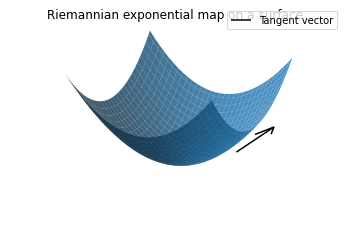

In [44]:
## Immersion Geometry
import matplotlib.pyplot as plt
import torch
import geomstats.visualization as viz
import geomstats.backend as gs
import autograd
class Immersion():
  """Class which is used to create immersion"""
  def surface_graph(self,x, y):
    """Rosenbrock function"""
    return (1 - x) ** 2 + 1 * (y - x ** 2) ** 2
  
  def convert_to_immersion(self,coord):
    """Creates the immersed version of tensors /vectors based on the associated surface function"""
    x = coord[..., 0]
    y = coord[..., 1]
    return gs.array(gs.transpose(gs.array([x, y, self.surface_graph(x, y)])))

  def compute_jacobian(self,func):
    """Uses the autograd library for computing jacobians"""
    return autograd.jacobian(func)
  
  def get_metric(self,d,e_d):
    """Pullback metric which takes the input dimensions and the embedding dimensions"""
    return PullbackMetric(dim=d, embedding_dim=e_d, immersion=self.convert_to_immersion)

def plot_surface(alpha=1., ax=None):
  """Plotting method for 3d surfaces"""
  if ax is None:
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
  
  x = y = gs.arange(-3.0, 3.0, 0.1)
  X, Y =gs.meshgrid(x, y)
  zs = gs.array(surface_graph(gs.flatten(X), gs.flatten(Y)))
  Z = gs.reshape(zs, X.shape)
  
  ax.plot_surface(
      gs.to_numpy(X), 
      gs.to_numpy(Y), 
      gs.to_numpy(Z), 
      alpha=alpha)

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Zm')
  #plt.show()
  return ax

if __name__=='__main__':
  print("Immersion and exponential mapping")
  """Take inputs vectors and tangents and instantiate object"""
  vector_a = gs.array([1.5,1.5])
  tangentvector_a = gs.array([1., 1.])
  immersion=Immersion()
  """dims specify input dimensions and embedding dims specify output immersion dimensions"""
  dims=2
  emb_dims=3
  """create pullback metric and create exponential map in R3"""
  metric=immersion.get_metric(dims,emb_dims)
  terminal_point=metric.exp(tangent_vec=tangentvector_a, base_point=vector_a)
  immersed_point_a = immersion.convert_to_immersion(vector_a)
  jc=immersion.compute_jacobian(immersion.convert_to_immersion)
  immersed_tangent_vec = gs.matmul(jc(vector_a), tangentvector_a)  
  immersed_end_point = immersion.convert_to_immersion(terminal_point)
  two_points = gs.vstack([immersed_point_a, immersed_end_point])
  print("Points a and b on the manifold : " ,two_points)
  #Plotting==== not mandatory=======
  ax = plot_surface(alpha=0.8)
  #change in matplotlib version  
  # ax.plot(
  #   immersed_point_a[0], 
  #   immersed_point_a[1], 
  #   immersed_point_a[2], 
  #   label='Initial point', marker="o", linestyle = 'None')


  arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
  arrow.draw(ax, color='black', label="Tangent vector")

  # ax.plot(
  #     immersed_end_point[0], 
  #     immersed_end_point [1], 
  #     immersed_end_point [2], 
  #     label='End point', marker="o", linestyle = 'None')

  ax.set_title('Riemannian exponential map on a surface')
  ax.legend()
  ax.grid(False)
  plt.axis('off');